## Loading data

import dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import collections
import numpy as np
import operator

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import pymorphy2
import re
from stop_words import get_stop_words
import pickle

load csv file 

In [2]:
fields = ['sku', 'comment', 'commentNegative', 'commentPositive', 'reting']
raw_data = pd.read_csv('feedback.csv/X_train.csv', delimiter=',', usecols=fields)
print('Data frame size:',raw_data.shape)

Data frame size: (15587, 5)


## Preprocessing

display the distribution of ratings

distribution by rating


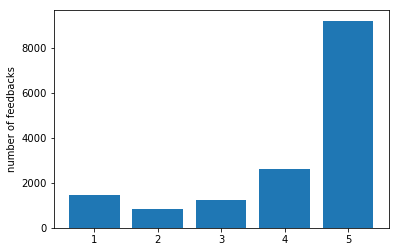

distribution by five / no five


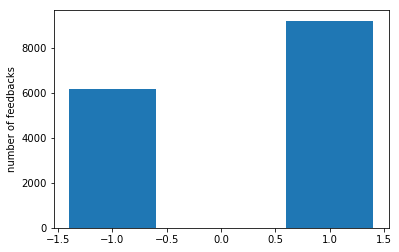

distribution by no five rating


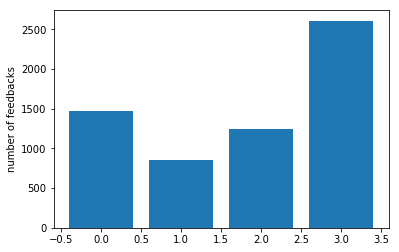

In [30]:
def arrangeBy(data, param):
    r_data = {}
    for row in data:
        if param in row:
            r = row[param]
            if r in r_data:
                r_data[r].append(row)
            else:
                r_data[r] = []
    return collections.OrderedDict(sorted(r_data.items()))

def plotDist(data):
    ratings = list(data.keys())
    numbers = list(map(lambda x: len(x), data.values()))

    plt.bar(ratings,numbers)
    plt.ylabel('number of feedbacks')
    plt.show()

rows_all = list(map(lambda x: x[1], raw_data.iterrows()))
rows = []

for row in rows_all:
    isFive = -1
    if not row['reting'].is_integer():
        continue
    if row['reting'] == 5:
        isFive = 1
    else:
        row['noFiveRating'] = -1 + row['reting']
    row['isFive'] = isFive
    rows.append(row)

print('distribution by rating')
ratings_data_by_rating = arrangeBy(list(rows),'reting');
plotDist(ratings_data_by_rating)

print('distribution by five / no five')
ratings_data_by_five = arrangeBy(list(rows),'isFive');
plotDist(ratings_data_by_five)

print('distribution by no five rating')
ratings_data_by_no_five_rating = arrangeBy(list(rows),'noFiveRating');
plotDist(ratings_data_by_no_five_rating)

normalize five / no five data

In [31]:
rows = list(ratings_data_by_five.values())

numbers = list(map(lambda x: len(x), rows))
feedbacks_per_five = int(sum(numbers) - max(numbers))

print('five feedbacks number:',feedbacks_per_five)

normal_rows_five = []
normal_rows_five = list(rows[0][:feedbacks_per_five])
normal_rows_five.extend(list(rows[1][:feedbacks_per_five]))
np.random.shuffle(normal_rows_five)
    
print('five / no five feedbacks number:',len(normal_rows_five))

five feedbacks number: 6175
five / no five feedbacks number: 12350


normalize no five data

In [32]:
rows = list(ratings_data_by_no_five_rating.values())

numbers = list(map(lambda x: len(x), rows))
feedbacks_per_no_five = min(numbers)

print('no five feedbacks number:',feedbacks_per_no_five)

normal_rows_no_five = []
normal_rows_no_five = list(rows[0][:feedbacks_per_no_five])
normal_rows_no_five.extend(list(rows[1][:feedbacks_per_no_five]))
normal_rows_no_five.extend(list(rows[2][:feedbacks_per_no_five]))
normal_rows_no_five.extend(list(rows[3][:feedbacks_per_no_five]))
np.random.shuffle(normal_rows_no_five)
    
print('no five feedbacks number:',len(normal_rows_no_five))

no five feedbacks number: 853
no five feedbacks number: 3412


check the distribution of ratings

normalized distribution for five / no five fata


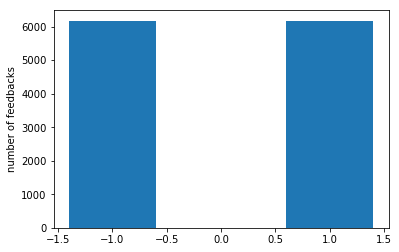

normalized distribution for no five ratings


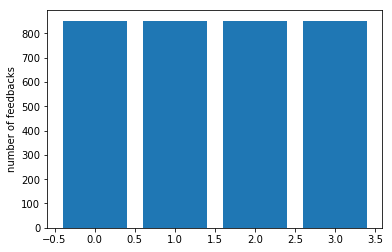

In [33]:
print('normalized distribution for five / no five fata')
plotDist(arrangeBy(normal_rows_five, 'isFive'))

print('normalized distribution for no five ratings')
plotDist(arrangeBy(normal_rows_no_five, 'noFiveRating'))

## Simple model

In [34]:
def evaluate_cross_validation(clf, X, y, K):
    cv = StratifiedKFold(K, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv) 
    print(scores)
    print("Mean score: {0:.3f} (+/-{1:.3f})".format(scores.mean(), scores.std()))
    
class RandomForestClassifierWithCoef(RandomForestClassifier):
    def fit(self, *args, **kwargs):
        super(RandomForestClassifierWithCoef, self).fit(*args, **kwargs)
        self.coef_ = self.feature_importances_

stop_words = stop_words = get_stop_words('ru')

five / no five model

In [35]:
count_vectorizer_five = CountVectorizer(min_df=0.0001, max_df=0.95, analyzer="word", stop_words=stop_words)

X = count_vectorizer_five.fit_transform((r['comment'] for r in normal_rows_five))
y = list(r['isFive'] for r in normal_rows_five)

frequent_words = dict(zip(count_vectorizer_five.get_feature_names(),np.asarray(X.sum(axis=0)).ravel()))
sorted_frequent_words = sorted(frequent_words.items(), key=operator.itemgetter(1))
print('the most frequent words', sorted_frequent_words[-20:])

clf_five = RandomForestClassifierWithCoef(n_estimators=512, min_samples_leaf=10, n_jobs=-1)
evaluate_cross_validation(clf_five, X, y, 6)

the most frequent words [('доволен', 703), ('рекомендую', 710), ('деньги', 715), ('видео', 721), ('супер', 733), ('купили', 736), ('купила', 740), ('цена', 765), ('хороший', 833), ('отличный', 844), ('модель', 855), ('звук', 889), ('отлично', 895), ('вообще', 904), ('быстро', 908), ('советую', 1004), ('пользуюсь', 1023), ('качество', 1089), ('купил', 1412), ('работает', 1631)]
[ 0.76019417  0.76044704  0.78279883  0.75510204  0.76190476  0.77599611]
Mean score: 0.766 (+/-0.010)


no five ratings model

In [36]:
count_vectorizer_no_five = CountVectorizer(min_df=0.0001, max_df=0.95, analyzer="word", stop_words=stop_words)

X = count_vectorizer_no_five.fit_transform((r['comment'] for r in normal_rows_no_five))
y = list(r['noFiveRating'] for r in normal_rows_no_five)

frequent_words = dict(zip(count_vectorizer_five.get_feature_names(),np.asarray(X.sum(axis=0)).ravel()))
sorted_frequent_words = sorted(frequent_words.items(), key=operator.itemgetter(1))
print('the most frequent words', sorted_frequent_words[-20:])

clf_no_five = RandomForestClassifierWithCoef(n_estimators=512, min_samples_leaf=10, n_jobs=-1)
evaluate_cross_validation(clf_no_five, X, y, 6)

the most frequent words [('сдавать', 183), ('вскрытия', 186), ('попроще', 192), ('функцию', 193), ('внешним', 196), ('тошибы', 196), ('урожая', 201), ('меломана', 202), ('меломану', 209), ('вертикальную', 210), ('судил', 214), ('ударе', 221), ('например', 226), ('дорого', 241), ('надёжен', 242), ('италия', 252), ('корпусов', 270), ('выбираем', 317), ('меломан', 368), ('семерку', 393)]
[ 0.43881119  0.41725352  0.42605634  0.39788732  0.40669014  0.44014085]
Mean score: 0.421 (+/-0.016)


## Smarter model

morphological normalization, etc.

In [37]:
morph = pymorphy2.MorphAnalyzer()

regex_clear = re.compile('[^а-яё]',re.DOTALL)
regex_space = re.compile('\s{1,}',re.DOTALL)

def clear(text):
    tmp = re.sub(regex_clear, ' ', text.lower().replace('ё', 'е'))
    return re.sub(regex_space, ' ', tmp)

def prepare(text):
    return text.lower()

def to_normal(word):
    return morph.parse(word)[0].normal_form
    
def normalize(text):
    words = []
    for word in text.split(' '):
        words.append(to_normal(word))
    norm=' '.join(words)  
    return norm.replace('ё', 'е')

class TextNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, texts):
        cleared = [clear(text) for text in texts]
        return [normalize(text) for text in texts]
    
class TextCleaner(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, texts):
        return [prepare(text) for text in texts]

In [38]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('count_vectorizer', Pipeline([
                ('selector', TextCleaner()),
                ('cv', CountVectorizer(min_df=0.0001, max_df=0.95, ngram_range=(4,4), analyzer="char_wb")),
                #('best', TruncatedSVD(n_components=100)),
            ])),
            ('tfidf', Pipeline([
                 ('selector', TextCleaner()),
                 ('tfidf', TfidfVectorizer(analyzer="word", stop_words=stop_words)),
                 #('best', TruncatedSVD(n_components=10)), 
             ])),
            ('count_vectorizer_default', Pipeline([
                ('selector', TextNormalizer()),
                ('cv', CountVectorizer(min_df=0.0001, max_df=0.95, stop_words=stop_words, analyzer='word')),                                
            ])),

        ],
        transformer_weights={ 
            'count_vectorizer': 1,
            'tfidf': 1,
            'count_vectorizer_default': 1
       },
    )),

    #('model', SVC(kernel='linear')) #rbf, sigmoid, polynomial
    ('model', RandomForestClassifierWithCoef(n_estimators=512, min_samples_leaf=5, n_jobs=-1))
    
])

five / no five model

In [39]:
comments_x = list(r['comment'] for r in normal_rows_five)
ratings_y = list(r['isFive'] for r in normal_rows_five)

evaluate_cross_validation(pipeline, comments_x, ratings_y, 3)

[ 0.76930549  0.77186589  0.77380952]
Mean score: 0.772 (+/-0.002)


no five ratings model

In [109]:
comments_x = list(r['comment'] for r in normal_rows_no_five)
ratings_y = list(r['noFiveRating'] for r in normal_rows_no_five)

evaluate_cross_validation(pipeline, comments_x, ratings_y, 3)

[ 0.41754386  0.41549296  0.44542254]
Mean score: 0.426 (+/-0.014)


In [111]:
def to_dataframe_five(normal_rows):
    tmp_df = pd.DataFrame()
    tmp_df['comment'] = list(r['comment'] for r in normal_rows)
    tmp_df['isFive'] = list(r['isFive'] for r in normal_rows)
    return tmp_df

def to_dataframe_no_five(normal_rows):
    tmp_df = pd.DataFrame()
    tmp_df['comment'] = list(r['comment'] for r in normal_rows)
    tmp_df['noFiveRating'] = list(r['noFiveRating'] for r in normal_rows)
    return tmp_df

feedback_five_df = to_dataframe_five(normal_rows_five)
X_train, X_test, y_train, y_test = train_test_split(feedback_five_df['comment'], feedback_five_df['isFive'], test_size = 0.05)
pipeline.fit(X_train, y_train)
print('five / no five report:')
print(classification_report(pipeline.predict(X_test), y_test))
pickle.dump(pipeline, open('mvideo.feedback.pickle.five', 'wb'))

feedback_no_five_df = to_dataframe_no_five(normal_rows_no_five)
X_train, X_test, y_train, y_test = train_test_split(feedback_no_five_df['comment'], feedback_no_five_df['noFiveRating'], test_size = 0.05)
pipeline.fit(X_train, y_train)
print('no five ratings report:')
print(classification_report(pipeline.predict(X_test), y_test))
pickle.dump(pipeline, open('mvideo.feedback.pickle.nofive', 'wb'))

five / no five report:
             precision    recall  f1-score   support

         -1       0.78      0.76      0.77       330
          1       0.73      0.76      0.74       288

avg / total       0.76      0.76      0.76       618

no five ratings report:
             precision    recall  f1-score   support

        0.0       0.68      0.43      0.53        69
        1.0       0.18      0.38      0.24        24
        2.0       0.19      0.47      0.27        17
        3.0       0.73      0.39      0.51        61

avg / total       0.58      0.42      0.46       171



In [115]:
pipeline_five = pickle.load(open('mvideo.feedback.pickle.five', 'rb'))
pipeline_no_five = pickle.load(open('mvideo.feedback.pickle.nofive', 'rb'))

def predict_rating(text):
    isFive = pipeline_five.predict([text])[0]
    if isFive == 1:
        return 5
    else:
        return int(pipeline_no_five.predict([text])[0] + 1)

In [116]:
for row in rows_all[:20]:
    print(row['comment'][:50],'... actual:',row['reting'],'predicted:',predict_rating(row['comment']))

2,5 года работала и все...устала! Лампочка горит и ... actual: 2.0 predicted: 1
Через 2 месяца после истечении гарантийного срока  ... actual: 2.0 predicted: 2
пользуюсь уже три недели. нареканий ни каких не бы ... actual: 4.0 predicted: 4
Ребят этот системный блок подойдёт для игры кс го  ... actual: 5.0 predicted: 5
я считаю, что яри замечательный телефон! Приятно д ... actual: 5.0 predicted: 5
Сегодня купила 2 таких вентилятора! Ужасный. Скоро ... actual: 1.0 predicted: 1
привезли ноут, по качеству корпуса и дизайну 5+. О ... actual: 5.0 predicted: 5
Купила этот увлажнитель, шумный, подсветка мешает  ... actual: 2.0 predicted: 2
Комбайн отличный. Пользуюсь 2 года. Пользуюсь в ос ... actual: 5.0 predicted: 5
Отличный аппарат. авто выключение вообще прелесть. ... actual: 5.0 predicted: 5
Смотрели сегодня эту модель в магазине, сначала со ... actual: 1.0 predicted: 1
Пользуюсь больше года, печь с самого начала плохо  ... actual: 2.0 predicted: 2
Пользуемся с женой вот уже несколько мес